In [1]:
import numpy as np
import matplotlib.pyplot as plt

Support Vector Machines (SVMs) are a type of supervised machine learning algorithm that can be used for classification and regression tasks. The goal of an SVM is to find a hyperplane (a line or a plane in a high-dimensional space) that separates the data points of different classes. The hyperplane that maximizes the margin, which is the distance between the hyperplane and the closest data points from each class, is chosen as the decision boundary.

In the case of a linear SVM, the decision boundary is a straight line (or a hyperplane) that separates the data points into different classes. For non-linearly separable data, SVMs can be used with a kernel trick, which maps the input data into a higher-dimensional space where the data becomes linearly separable.

SVMs are particularly useful when the data has many features and the classes are well separated. They are also robust to noise and outliers. In addition to that, SVMs are very effective in high-dimensional spaces and are memory efficient as they only use a subset of the data points, called support vectors, to define the decision boundary.

In short, support vector machines are a powerful and versatile machine learning algorithm that can be used for a variety of tasks, especially when the data is high-dimensional and the classes are well separated.

The equation of a hyperplane in a $d$-dimensional space is given by:

$$\vec{w}^T \vec{x}_i + b = 0$$

where $\vec{w}$ is a $d$-dimensional vector normal to the hyperplane, $x$ is a d-dimensional vector representing the input data point, and $b$ is a scalar bias term.

The margin can be defined as:

$$m = \frac{2}{||\vec{w}||}$$

The objective of the linear SVM is then to maximize the margin while ensuring that the data points are correctly classified. or

We can find a support vector by solving

$$
\min_{\vec{w} \in\mathbb{R}^n, b \in\mathbb{R}} ||\vec{w}||^2 
$$

subject to 

$$
y_i \left ( \vec{w}^T \vec{x_i} - b \right) \geq 1 \;\;\;, \forall i
$$

Then we classify a new point $\vec{p}$ by

$$
c \left( \vec{p} \right) = \operatorname{sign}{\left ( \vec{w}^T \vec{p} + b \right)} \;\;\;, c \in \{-1, 1\}
$$

# Linear data

## Implementation with pure python

### Generate synthetic data

In [2]:
def clouds(num_points=100):
    """
    Generate synthetic data for a two-class classification problem.

    Parameters:
    -----------
        `num_points` (`int`): Number of points to generate for each class. (default=100)

    Returns:
    --------
        `tuple`: A tuple of two lists, `X` and `y`, where `X` is a list of points and `y` is a list of labels for each point.
    """
    centers = [(1, 1), (-1, -1)]
    spreads = [0.5, 0.7]
    labels = [-1, 1]

    X = []
    y = []

    for center, spread, label in zip(centers, spreads, labels):
        X += np.random.multivariate_normal(
            center, spread * np.identity(2), num_points
        ).tolist()
        y += [label] * num_points

    return X, y

This function generates synthetic data for a two-class classification problem. The data consists of two clusters of points, with one cluster centered at `(1,1)` and the other at `(-1,-1)`. The spread of each cluster is controlled by the spreads list, and the labels of the points in each cluster are controlled by the `labels` list. The number of points in each cluster is determined by the `num_points` argument. The function returns the generated data as a tuple of two lists, `X `and `y`, where `X` is a list of points and `y` is a list of labels for each point.

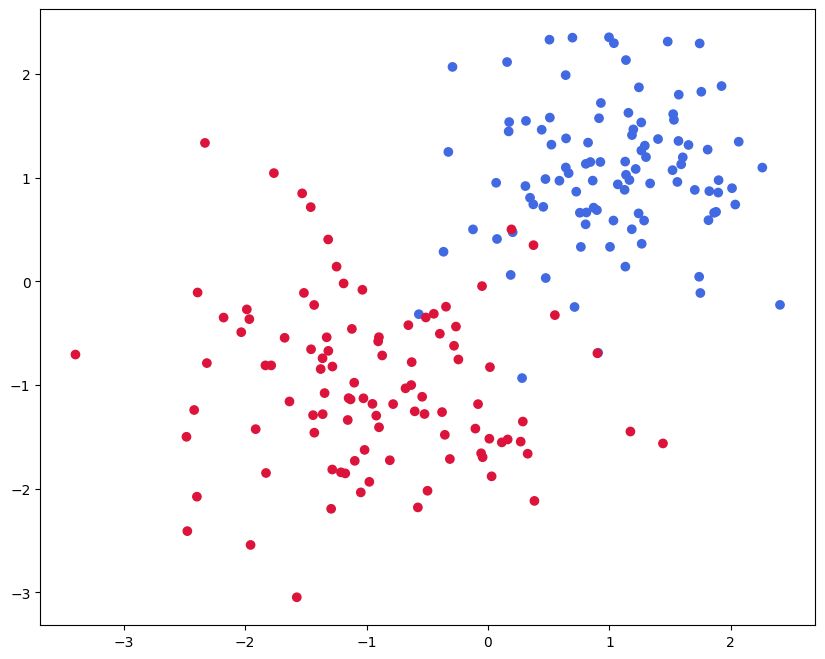

In [3]:
X, y = clouds()
colors = ["crimson" if label == 1 else "royalblue" for label in y]
plt.figure(figsize=(10, 8))
plt.scatter(np.array(X)[:, 0], np.array(X)[:, 1], c=colors)
plt.show()

The above code will use the function `clouds()` to generate a dataset, and then it will use the labels `y` to color the data points differently depending on the class they belong to.
It is using two list comprehensions to create two separate arrays, `X` and `y`. The first one is creating a list `'colors'` which will hold either `'crimson'` or `'royalblue'` depending on the value of the label.
Then, it is using the ``Matplotlib` library to create a scatter plot of the data, where the x-coordinates of the data points are given by the first column of the `X` array and the y-coordinates are given by the second column. The `'c'` parameter is used to set the color of each data point according to the corresponding entry in the colors list.

### Defining the loss function

We include the constraint we need to classify the data correctly as penalty with weigt $\lambda > 0$

$$
l(\vec{w}, b) = ||\vec{w}||^2 + \lambda \sum_{i=1}^n \max \left(0, y_i \left(\vec{w}^T \vec{x}_i - b\right)\right)
$$

the larger $\lambda$, the more important it is to classify the data correctly.

In [4]:
def loss(support_vector, X, y, penalty=1e5):
    """
    Computes the loss for a given set of support vector and parameters.

    Parameters:
    -----------
        `support_vector`: 1-D array of support vectors.
        `X`: 2-D array of input data, where each row is a feature vector for a data point.
        `y`: 1-D array of labels for the data points in `X`, where each label is either 1 or -1.
        `penalty`: `float`, penalty term to trade off correct classification of training data and margin size.

    Returns:
    --------
        `float`: Loss value.
    """
    w = support_vector[1:]
    b = support_vector[0]

    norm = np.linalg.norm(w) ** 2
    constraint = sum(max(0, 1 - y[i] * (w.dot(X[i]) - b)) for i, _ in enumerate(y))

    return norm + penalty * constraint

This function defines a loss function for support vector machines (SVMs). The loss function is used to train an SVM model, by minimizing the value of the loss function with respect to the model's parameters (i.e. the support vectors).

The function takes four inputs:

* `support_vector`: a 1-D array of model parameters, including the bias term `b` and the weight vector `w`.
* `X`: a 2-D array of input data, where each row is a feature vector for a data point
* `y`: a 1-D array of labels for the data points in `X`, where each label is either 1 or -1
* `penalty`: a scalar value that controls the trade-off between the margin maximization and the misclassification error.

The function uses the variables `w`, `b`, `norm` and `constraint` to calculate the loss.
It then calculates the value of the regularization term, which is the norm of the weight vector. Then it calculates the value of the hinge loss, which measures the misclassification error. The hinge loss is the sum of the `(0, 1 - y[i] * (w.dot(X[i]) - b))` over `i`, and is defined by the constraint variable, which constrains the function to the range `[0,+inf]`.

Finally, the function returns the sum of the regularization term and the hinge loss, multiplied by the penalty term.
The returned value of the function is a scalar number, a smaller number indicates a better model(more accurate) while a higher number indicates a poor model.

### minimize the loss

In [5]:
from qiskit.algorithms.optimizers import L_BFGS_B

optimizer = L_BFGS_B()
result = optimizer.minimize(lambda sv: loss(sv, X, y), x0=np.random.random(3))
support_vector = result.x

These lines are using the `L-BFGS-B` optimizer, which is an optimization algorithm for large-scale bound-constrained problems, to minimize the loss function defined by the `loss()` function.

It creates an instance of the optimizer and then uses its `minimize()` method to minimize the loss function. The `minimize()` method takes a callable function that returns the loss and the initial guess for the support vector as inputs. In this case, the loss function is defined as `lambda sv: loss(sv, X, y)` and the initial guess for the support vector is `np.random.random(3)`, which is an array of random numbers between 0 and 1, this is to find a better solution to the problem. The method returns an object that has information about the optimization process and the final solution.

The final solution of the support vector is stored in the variable `support_vector`, which is accessed via the `x` attribute of the result object, the value in this variable are the minimized values of the `support_vector` parameters.

In [6]:
def classify(point, support_vector):
    """
    Classify an input point given the support vector.

    Parameters:
    -----------

        `point`: 1-D array, Input point to classify.
        `support_vector`: 1-D array of SVM parameters.

    Returns:
    --------
        `float`: Class of the input point, 1 or -1.
    """
    w = support_vector[1:]
    b = support_vector[0]

    return np.sign(w.dot(point) + b)

This function is a simple binary classifier that uses a trained support vector machine (SVM) to classify a new point.

The function takes two inputs:

* `point`: a 1-D array representing the feature vector of the point to be classified.
* `support_vector`: a 1-D array of the SVM's parameters, including the bias term `b` and the weight vector `w`.

It uses the variables `w` and `b`, which are extracted from the `support_vector` input, to calculate the dot product of `w` and `point`. Then it adds the bias term `b` to the dot product and applies the sign function to the result, which returns 1 or -1 depending on whether the value is positive or negative. This value represents the class of the point, 1 for one class and -1 for the other class.

In essence, the `classify` function calculates the dot product of the weight vector and the point and then returns whether this dot product value is positive or negative, positive means the point belongs to the class 1, negative means the point belongs to the class -1.

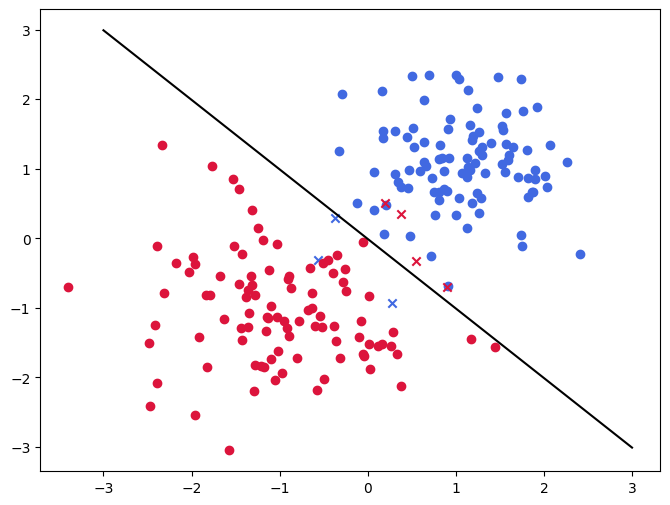

In [7]:
predicted = [classify(point, support_vector) for point in X]
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = [
    "o" if label == predicted_label else "x"
    for label, predicted_label in zip(y, predicted)
]

plt.figure(figsize=(8, 6))
for point, marker, color in zip(X, markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)

b, w = support_vector[0], support_vector[1:]
x1 = np.linspace(-3, 3, num=100)
x2 = -1 / w[1] * (w[1] * x1 + b)
plt.plot(x1, x2, "k-")
plt.show()


The above code will use the `classify()` function and the `support_vector` obtained from the optimization step to classify all the data points in the dataset, `X`.
It is using a list comprehension to create a list `predicted` which will hold the predicted label of the class for each data point in `X`. The correct predictions are plotted with `'o'` marker while incorrect predictions with `'x'` marker.

Then, it plots the decision boundary of the classifier using the equation `w[0]*x1 + w[1]*x2 + b = 0` and the obtained support vector . The decision boundary is the line that separates the two classes, the points that lie on one side of the line belong to one class and the points that lie on the other side of the line belong to the other class.

## Implementation with `sklearn`

In [8]:
from sklearn.svm import SVC

model = SVC()
model.fit(X, y)

sk_predict = model.predict(X)

This code is using the scikit-learn library's implementation of the Support Vector Classifier (SVC) to train a model on the input dataset `X`, `y`.

It creates an instance of the `SVC` class and then uses the fit method to train the model on the input data `X`, `y`. The fit method takes two inputs, the input data `X` and the labels `y`, and it estimates the parameters of the model.

After training, the predict method is used to predict the label for each data point in the input dataset, `X`. The predict method takes the input data as input and returns an array of the predicted labels, in this case, the predicted labels are stored in the variable `sk_predict`.

It's worth mentioning that the `SVC` class in scikit-learn library is an implementation of support vector classification algorithm with a linear kernel by default. This means that the model is trying to find a linear decision boundary to separate the classes.
It can also use different kernel function like `rbf`, `poly` etc. With different kernel function, it will use different algorithm to find a decision boundary, this allows to tackle more complex problems.

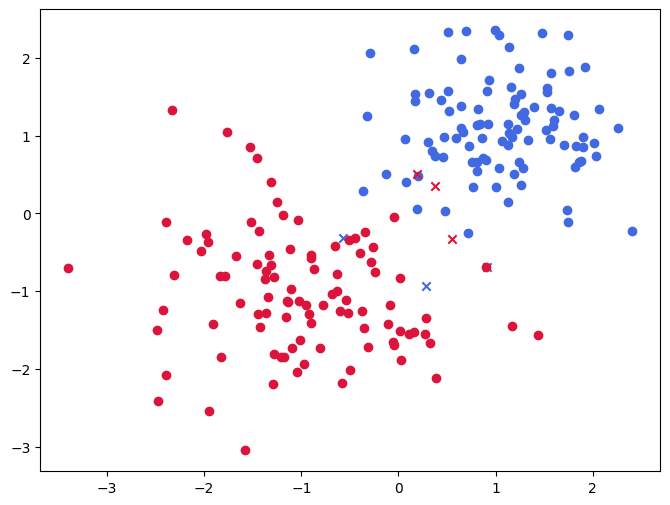

In [9]:
colors = ["crimson" if label == 1 else "royalblue" for label in y]
markers = [
    "o" if label == predicted_label else "x"
    for label, predicted_label in zip(y, sk_predict)
]

plt.figure(figsize=(8, 6))
for point, marker, color in zip(X, markers, colors):
    plt.scatter(point[0], point[1], color=color, marker=marker)
plt.show()


It is worth mentioning that, unlike previous examples, this code snippet doesn't plot decision boundary, because sklearn's implementation of SVC class doesn't provide the weights and bias directly, in order to plot decision boundary one needs to use different methods.

# Non-linear data

## Generate synthetic data

In [10]:
def circle(num_points=250):
    """
    Generates a synthetic dataset of points distributed in a circle.

    Parameters:
    ------------

        `num_points`: `int`, the number of points in the dataset.

    Returns:
    --------

        `tuple`: (`points`, `labels`), where points is a 2D array of size `(num_points, 2)` and labels is a 1D array of size `num_points`.
    """
    points = 1 - 2 * np.random.random((num_points, 2))
    radius = 0.6
    labels = [1 if np.linalg.norm(point) > radius else -1 for point in points]
    return points, labels

This function creates a synthetic dataset of points that are randomly distributed in a circle.
The function takes a single input, `num_points`, which is an integer that represents the number of points in the dataset. It's set to 250 by default, if no input is provided.

It generates the points by creating a 2D array with shape `(num_points, 2)` of random numbers between 0 and 1, then it scales these numbers by subtracting 1, and then multiplying by -2.

The radius of the circle is set to 0.6, it creates a list labels of size `num_points` that holds the labels for each point in the dataset. It uses a list comprehension that iterates over each point and for each point it calculates the euclidean distance from the origin to the point, and compares that with the radius. If the euclidean distance is larger than the radius, it assigns the point the label 1, otherwise, it assigns the label -1.

It returns the points, and labels in a tuple, the points being the 2D array of points and labels being the labels for each point.

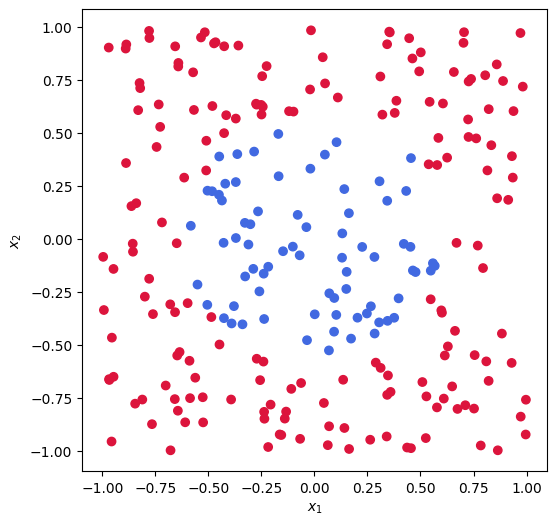

In [11]:
points, labels = circle()
colors = ["crimson" if label == 1 else "royalblue" for label in labels]

plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c=colors)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

This code snippet creates an instance of the synthetic data using `circle()` function, then using matplotlib library, it's creating a scatter plot of the points in the dataset. The x-coordinates of the data points are given by the first column of the points array and the y-coordinates are given by the second column. The `color` parameter is used to set the color of each data point according to the corresponding entry in the `colors` list which is created in previous line.

## Kernel Trick

We introduce a non-linear feature transformation $\phi$ into a Hilbert space $\mathcal{V}$

$$\phi : \mathbb{R}^n \rightarrow \mathcal{V}$$

Rewrite the objective function such that only inner products of the points are necessary

$$
\max_\alpha \left( \sum_{i=1}^n \alpha_i -\frac{1}{2} \sum_{i,j=1}^n \alpha_i \alpha_j y_i y_j \vec{x}_i^T \vec{x}_j  \right)
$$

subject to

$$
\sum_{i=1}^n \alpha_i y_i = 0
$$

now we can find feature maps $\phi$ evaluating the inner product

$$
k\left(\vec{x}_i, \vec{x}_j\right) = \vec{x}_i^T \vec{x}_j = \left< \vec{x}_i, \vec{x}_j \right>
$$

Then, our disicion function is

$$
c(\vec{p}) = \operatorname{sign}{\left ( \left < \vec{w}, \phi \left( \vec{p} \right) \right> + b \right)}, \;\;\; c \in \{-1, 1\}
$$

In [12]:
def feature_map(x):
    """
    Transforms a 2D feature vector into a 3D feature vector.

    Parameters:
    ----------

        `x` : array-like, The input feature vector of shape `(2,)`

    Returns:
    --------

        `array`: The transformed 3D feature vector of shape `(3,)``
    """
    return np.array([x[0], x[1], x[0] ** 2 + x[1] ** 2])

This function is a simple feature map function, it transforms a 2D feature vector into a 3D feature vector.
It takes an input `x`, which is a 2D feature vector and applies a transformation to it, and it returns a new feature vector, which is a 3D array.

It's essentially adding two new features to the input feature vector, the first one is the `x[0]` (x-coordinate) of the input point, the second one is the `x[1]` (y-coordinate) of the input point, and the third one is the euclidean distance from the origin to the input point, which is `x[0] ** 2 + x[1] ** 2`.

This feature map function is useful for non-linear classification problem, it creates non-linear decision boundary by adding new features to the input data, in this case it's adding distance to the origin feature, which is useful for classification in a circular region.

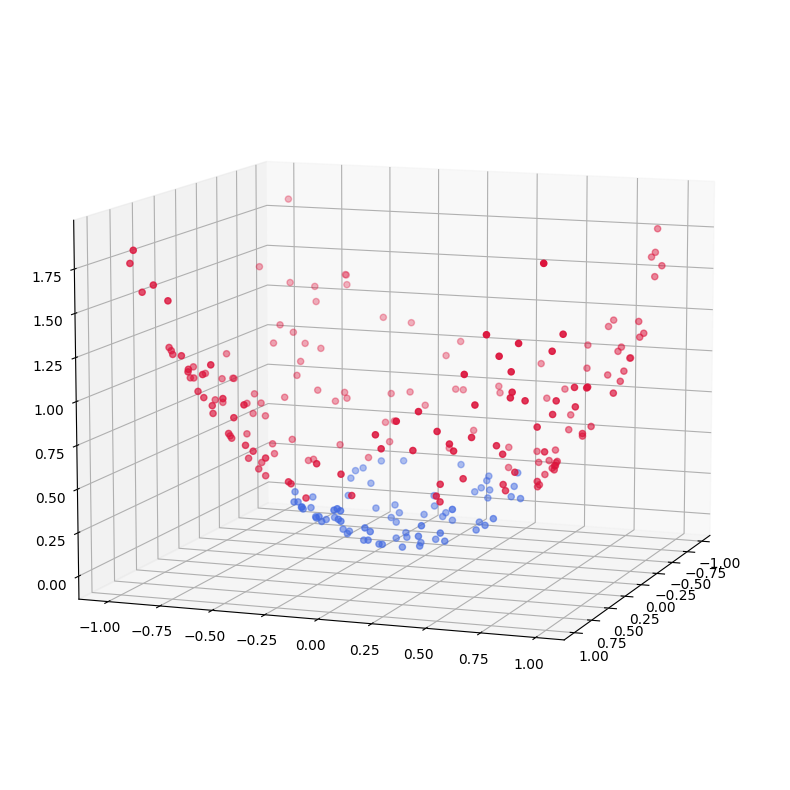

In [13]:
embeded_points = np.array([feature_map(point) for point in points])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(embeded_points[:, 0], embeded_points[:, 1], embeded_points[:, 2], c=colors)
ax.view_init(10, 20)

This code snippet is applying the `feature_map()` function to each point in the dataset, it takes the 2D points, and applies the `feature_map()` to get the 3D points (`embedded_points`) .

Then it's creating a 3D scatter plot of the points, using the Matplotlib library, by passing the transformed 3D points to the scatter function of the `Axes3D` class. The x, y and z coordinates of the points are given by the first, second and third column of the `embedded_points` array. The `c` parameter is used to set the color of each data point according to the corresponding entry in the `colors` list.

It uses `view_init(10, 20)` to adjust the viewing angle of the plot. It's rotating the plot by 10 degrees around the x-axis and 20 degrees around the y-axis.

It's worth noting that, this code snippet is useful when the data points are non-linearly separable, by applying the `feature_map` function, it maps the data points to a higher dimensional space, where it becomes linearly separable, this is known as the kernel trick.

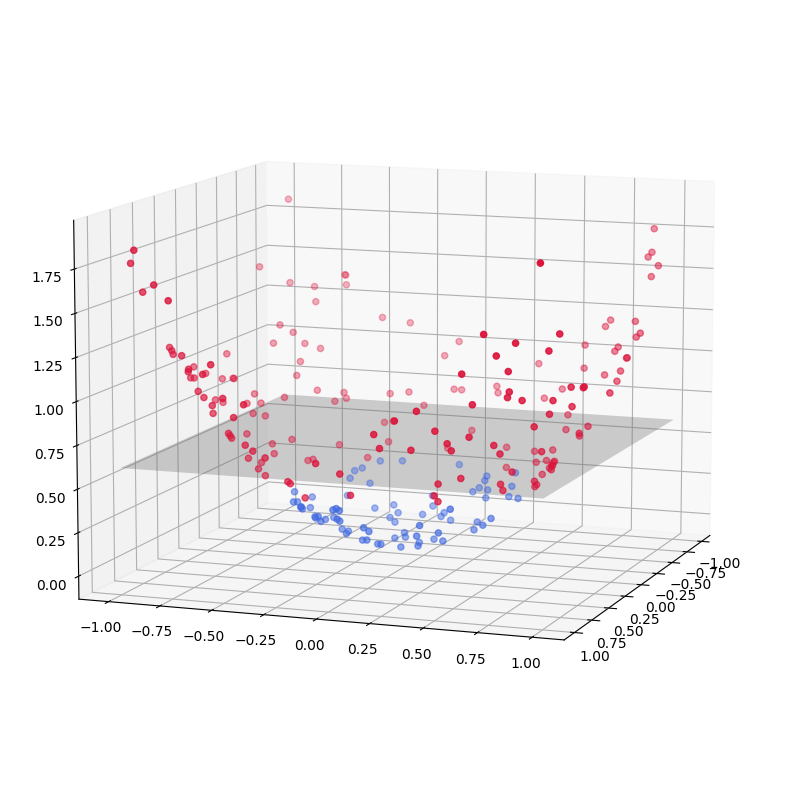

In [14]:
embeded_points = np.array([feature_map(point) for point in points])

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(projection="3d")
ax.scatter(embeded_points[:, 0], embeded_points[:, 1], embeded_points[:, 2], c=colors)

x, y = np.meshgrid([1, -1], [1, -1])
ax.plot_surface(x, y, 0.6 * np.ones_like(x), alpha=0.3, color="grey")

ax.view_init(10, 20)

Additionally, it creates a 3D surface plot to show the decision boundary of the classifier, it uses numpy function `meshgrid` to create x and y coordinates and then it uses `plot_surface` function from Axes3D class to plot the surface. The surface is centered at 0.6 in the z-axis and it's shown as a grey plane with alpha of 0.3, the plane is created to show the decision boundary visually, as the points inside the plane has one label and the points outside of the plane has other labels, in this case the radius of the circle.

This way the resulting plot will be much more informative, it not only shows the data points and the class labels, but also shows the decision boundary of the classifier.

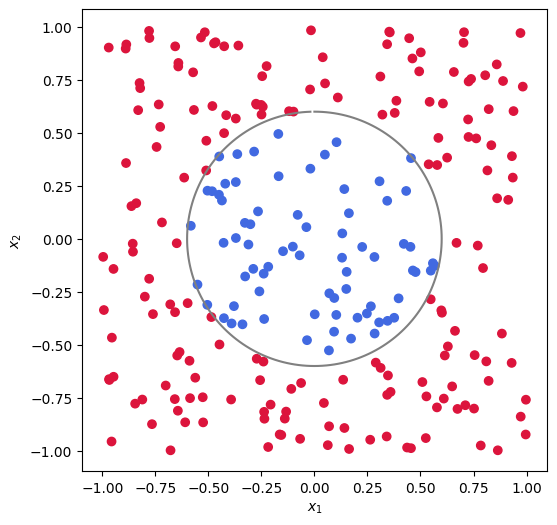

In [15]:
plt.figure(figsize=(6, 6))
plt.scatter(points[:, 0], points[:, 1], c=colors)

angles = np.linspace(0, 2 * np.pi, num=200, endpoint=False)
x = 0.6 * np.sin(angles)
y = 0.6 * np.cos(angles)
plt.plot(x, y, color="grey")

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.show()

It creates a plot of a circle with radius 0.6 in order to visually represent the decision boundary. It uses numpy's `linspace` function to create a set of angles from 0 to $2 \pi$. Then it computes the corresponding x and y coordinates for each angle using the sine and cosine functions. And finally, it plots these points in a 2D plot using the `plot` function from Matplotlib, the color of the line is set to `grey`.

It's worth mentioning that this way of representation the decision boundary is useful when the data points are in a circular pattern, which is in this case, as the data points are arranged in a circular pattern it makes sense to use a circle to represent the decision boundary.